# Visualize the non-linear dynamics of action potential using the simple FitzHugh-Nagumo model

In [1]:
using Pkg
Pkg.activate("../")
using DynamicalSystems
using DifferentialEquations
using CairoMakie
path_figures="/Users/johannes/research/figures_perspective_heart_brain/subfigures/"
#path_figures="/Users/johannes/research/figures_perspective_heart_brain/figures/subfigures/"

  Activating project at `~/git/projects/perspective_heart_and_brain`


"/Users/johannes/research/figures_perspective_heart_brain/subfigures/"

In [2]:
Dt = 1e-3
# Differential equations of fitzhugh-nagumo model
# References:
# Datseris & Parliz, Nonlinear Dynamics, 2022
# see also: https://link.springer.com/referenceworkentry/10.1007/978-1-4614-7320-6_147-1
# Original: https://www.cell.com/biophysj/pdf/S0006-3495(61)86902-6.pdf
function fitzhugh_nagumo_datseris_parlitz(;a=3, b=0.2, ϵ=0.01, return_nullclines=false)
    function f(u, p, t)
        v, w = u
        I, = p
        dv = a*v*(v-b)*(1-v) - w + I(t)
        dw = ϵ*(v-w)
        return SVector(dv, dw)
    end
    if return_nullclines
        w1(v) = a*v*(v-b)*(1-v)
        w2(v) = v
        return f, w1, w2
    end
    return f
end
function fitzhugh_nagumo_wikipedia(;a=0.7, b=0.8, τ=12.5, return_nullclines=false)
        function f(u, p, t)
            v, w = u
            I, = p
            dv = v - v^3/3 - w + I(t)
            dw = (v + a - b*w)/τ
            return SVector(dv, dw)
        end
        if return_nullclines
            w1(v) = v - v^3/3
            w2(v) = (v + a)/b
            return f, w1, w2
        end
        return f
    end

fitzhugh_nagumo_wikipedia (generic function with 1 method)

In [3]:
f, w1, w2 = fitzhugh_nagumo_datseris_parlitz(ϵ=0.05, b=0.1, return_nullclines=true)

(f, w1, w2)

In [4]:
using ChaosTools
# get the fixed points
fhn = CoupledODEs(f, [0.0, 0.0], [x-> 0, ])
fp,_ = fixedpoints(fhn, IntervalBox(interval(-3,1), interval(-1,1)))
print("fixed points: ", fp[1])


fixed points: [8.330343701897909e-29, 8.321439534045496e-29]

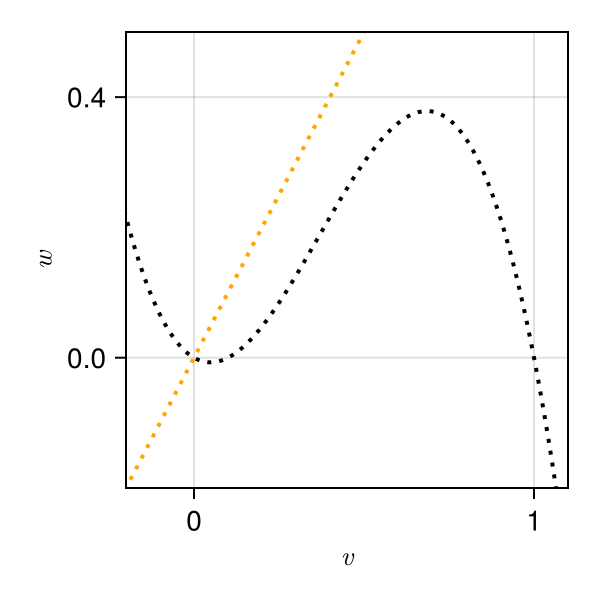

In [5]:
# Draw the state space of the model with nullclines
fig = Figure(size = (300, 300))
ax = Axis(fig[1, 1], xlabel = L"$v$", ylabel = L"$w$", xticks = 0:1:1, yticks = 0:0.4:0.4)
# Draw the nullclines
v = -2:0.01:2
lines!(ax, v, w1.(v), color = :black, linewidth = 2, linestyle = :dot, label = "w1")
lines!(ax, v, w2.(v), color = :orange, linewidth = 2, linestyle = :dot, label = "w2")
xlims!(ax, -0.2, 1.1)
ylims!(ax, -0.2, 0.5)
# draw vector field (TODO)
# draw perturbations (TODO)
fig


In [6]:
# single action potential
u0=fp[1]
stimulus(t) = 10<t<12 ? 0.2 : 0.0
p = [stimulus,]
prob = ODEProblem(f, u0, (0,75), p)
sol = solve(prob, dtmax=1.0, saveat=0.01)
t = sol.t;
v = map(x->x[1], sol.u);


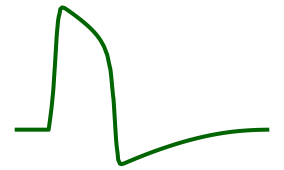

In [7]:
cm = 28.3465 # pt
fig = Figure(size = (5*cm, 3*cm), fontsize=10, figure_padding = 1, backgroundcolor = :transparent)
ax = Axis(fig[1,1]; xgridvisible = false, ygridvisible = false, backgroundcolor = :transparent)
hidedecorations!(ax)
hidespines!(ax)
ylims!(ax, -0.3, 1)

lines!(ax, t, v, linewidth=2, color=colorant"darkgreen")

# save as pdf
save(path_figures*"action_potential_fitzhugh_nagumo_single.pdf", fig, pt_per_unit = 1)
fig

## Create time trace and phase-space plot with multiple excitations

In [8]:
using ChaosTools
using IntervalArithmetic
import IntervalArithmetic.(..)

In [9]:
# Extract individual trajectories from solution
function extracttraj(sol)
    numvars = length(sol.u[1])
    return sol.t, [getindex.(sol.u,i) for i in 1:numvars]...
end

# Split trajectory into different parts given by intervals
splittraj(intervals, sol) = splittraj(intervals, extracttraj(sol)...)
function splittraj(intervals, t::AbstractVector{T}, us::Vararg{AbstractVector{T}, N}) where {T, N}
    (length(t) == only(unique(length.(us)))) || error("Lengths of t and the different `u`s are not identical")
    ts = Vector{Vector{T}}()
    uss = [Vector{Vector{T}}() for _ in 1:N]
    for interval in intervals
        idcs = in.(t, interval)
        
        push!(ts, t[idcs])
        for i in 1:N
            push!(uss[i], us[i][idcs])
        end
    end
    return ts, uss...
end

splittraj (generic function with 2 methods)

In [10]:
##
stim_intervals = [  (0.0 .. 1.0, 0.0), # no stim in first interval
                    (2.0 .. 3.0, 0.12),
                    (21.0 .. 22.0, 0.2),
                    (51.0 .. 52.0, 0.2)]
stimamp(si) = si[2]
stimstart(si) = si[1].lo
stimend(si) = si[1].hi
responsestart(si) = stimstart(si)
responsestart(sis,i) = responsestart(sis[i])
responseend(sis,i) = i < length(sis) ? sis[i+1][1].lo : ∞

plot_intervals = [responsestart(stim_intervals,i) .. responseend(stim_intervals,i) for i in 1:length(stim_intervals)]
function I_stim(t)
    for (iv, s) ∈ stim_intervals
        if t ∈ iv
            return s
        end
    end
    return 0.0
end

# fixed point
dtsample = 0.01

u0=fp[1]
p = [I_stim,]
prob = ODEProblem(f, u0, (0,75), p)
sol = solve(prob, dtmax=1.0, saveat=dtsample)
tall,vall,wall = extracttraj(sol)
tp, vp, wp = splittraj(plot_intervals, sol)

([[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  1.91, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.0], [2.0, 2.01, 2.02, 2.03, 2.04, 2.05, 2.06, 2.07, 2.08, 2.09  …  20.91, 20.92, 20.93, 20.94, 20.95, 20.96, 20.97, 20.98, 20.99, 21.0], [21.0, 21.01, 21.02, 21.03, 21.04, 21.05, 21.06, 21.07, 21.08, 21.09  …  50.91, 50.92, 50.93, 50.94, 50.95, 50.96, 50.97, 50.98, 50.99, 51.0], [51.0, 51.01, 51.02, 51.03, 51.04, 51.05, 51.06, 51.07, 51.08, 51.09  …  74.91, 74.92, 74.93, 74.94, 74.95, 74.96, 74.97, 74.98, 74.99, 75.0]], [[8.330343701897909e-29, 8.222324371862368e-29, 8.114775601595678e-29, 8.007966665964554e-29, 7.901714771040548e-29, 7.795857639136881e-29, 7.690232992566776e-29, 7.584678553643456e-29, 7.479032044680144e-29, 7.37313118799006e-29  …  -6.929576044217619e-29, -6.983874067582594e-29, -7.038341233150954e-29, -7.093034408881988e-29, -7.148010462734985e-29, -7.20332626266924e-29, -7.259038676644042e-29, -7.315204572618681e-29, 2.122754401861077e-6, 0.000202

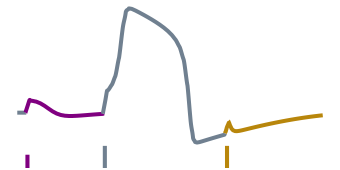

In [11]:
# plot_colors = [
#         RGBf(0., 0., 0.),
#         RGBf(0.7, 0.7, 0),
#         RGBf(0.7, 0., 0.7),
#         RGBf(0., 0.7, 0.7)
#     ]

plot_colors= [colorant"slategray", colorant"purple", colorant"slategray", colorant"darkgoldenrod"]

cm = 28.3465 # pt
fig = Figure(size = (6*cm, 3*cm), fontsize=10, figure_padding = 1, backgroundcolor = :transparent)
ax = Axis(fig[1,1]; xgridvisible = false, ygridvisible = false, backgroundcolor = :transparent)
hidedecorations!(ax)
hidespines!(ax)

# plot membrane potential and stimuli
for (t,v,w,si,c) in zip(tp, vp, wp, stim_intervals, plot_colors)
    lines!(ax, t, v, color = c, linewidth = 2)

    # stimuli
    iv, a = si
    iv = [iv.lo, iv.hi]

    band!(iv, -0.5, -0.5 + a, color = c)
end


ylims!(ax, -0.5, 1)
# save as pdf
save(path_figures*"action_potential_fitzhugh_nagumo_multiple.pdf", fig, pt_per_unit = 1)
fig

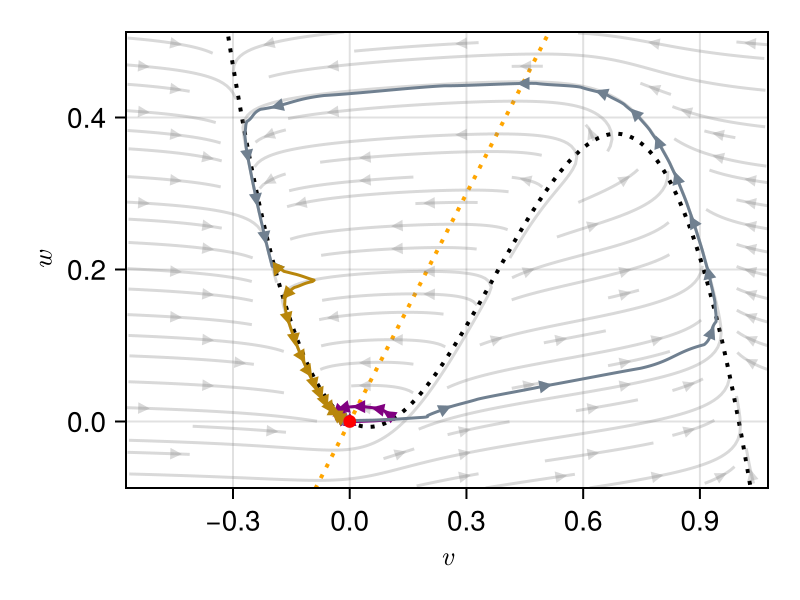

In [12]:
# plot phase space 
# Draw the state space of the model with nullclines
fig = Figure(size = (400, 300))
ax = Axis(fig[1, 1], xlabel = L"$v$", ylabel = L"$w$")

vstep=0.15
wstep = 0.075
grid_v = -0.5:vstep:1.1 # also used for plot range
grid_w = -0.05:wstep:0.5 # extrema are also used for streamplot
arrowcolor = RGBAf(0.5, 0.5, 0.5, 0.3)

vrange = extrema(grid_v) .+ (-0.5, 0.5).*vstep
wrange = extrema(grid_w) .+ (-0.5, 0.5).*wstep
xlims!(ax, vrange)
ylims!(ax, wrange)

# Draw the nullclines
vs = -2:0.01:2
lines!(ax, vs, w1.(vs), color = :black, linewidth = 2, linestyle = :dot, label = "w1")
lines!(ax, vs, w2.(vs), color = :orange, linewidth = 2, linestyle = :dot, label = "w2")


streamplot!(ax, (x,y) -> Point2(f([x, y], [x->0,], 0)...), vrange, wrange;
            gridsize = (20,20,20),
            arrow_size = 8, color = x->arrowcolor)

for (t,v,w,si,c) in zip(tp, vp, wp, stim_intervals, plot_colors)
    #if we haven't done a stream plot
    #only indicate trajectory direction outside stimuli
    if t ∉ si[1]
        for (v_, w_) in zip(v[1:200:end], w[1:200:end])
            dv, dw = f([v_, w_], [x->0,], 0)
            arrows!(ax, [v_], [w_], [dv], [dw], color = c, align = :head, lengthscale = 1e-5)
        end
    end
    lines!(ax, v, w, color = c)
end

scatter!(ax, [u0[1]], [u0[2]], marker = :circle, color = :red)

fig

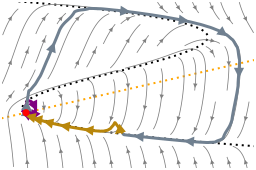

In [13]:
# plot phase space 
# Draw the state space of the model with nullclines
cm = 28.3465 # pt
fig = Figure(size = (4.5*cm, 3*cm), fontsize=10, figure_padding = 1, backgroundcolor = :transparent)
ax = Axis(fig[1,1]; xgridvisible = false, ygridvisible = false, backgroundcolor = :transparent)
hidedecorations!(ax)
hidespines!(ax)

vstep=0.1
wstep = 0.075
grid_v = -0.5:vstep:1 # also used for plot range
grid_w = -0.05:wstep:0.5 # extrema are also used for streamplot
arrowcolor = RGBAf(0.5, 0.5, 0.5, 1)

vrange = extrema(grid_v) #.+ (-0.5, 0.5).*vstep
wrange = extrema(grid_w) #.+ (-0.5, 0.5).*wstep
#x=w , y=v
xlims!(ax, wrange)
ylims!(ax, vrange)

# Draw the nullclines
vs = -2:0.01:2
lines!(ax, w1.(vs), vs, color = :black, linewidth = 1, linestyle = :dot, label = "w1")
lines!(ax, w2.(vs), vs, color = :orange, linewidth = 1, linestyle = :dot, label = "w2")


function map_f(w,v)
    dv,dw = f([v, w], [x->0,], 0)
    return Point2(dw, dv)
end 
streamplot!(ax, map_f, wrange, vrange;
            gridsize = (15,15,15),
            arrow_size = 3, linewidth = 0.4, color = x->arrowcolor)

for (t,v,w,si,c) in zip(tp, vp, wp, stim_intervals, plot_colors)
    #if we haven't done a stream plot
    #only indicate trajectory direction outside stimuli
    if t ∉ si[1]
        for (v_, w_) in zip(v[30:400:end], w[30:400:end])
            dv, dw = f([v_, w_], [x->0,], 0)
            arrows!(ax, [w_], [v_], [dw], [dv], color = c, align = :head, arrowsize=7,  lengthscale = 1e-5)
        end
    end
    lines!(ax, w, v, color = c, linewidth = 1.5)
end

scatter!(ax, [u0[2]], [u0[1]], marker = :circle, color = :red, markersize=5)

# save as pdf
save(path_figures*"action_potential_fitzhugh_nagumo_phase-space.pdf", fig, pt_per_unit = 1)
fig